# Practical Session. Variational Autoencoders

During this practical session you will implement a vanilla variational autoencoder on MNIST and then a modification of VAE that can be used for semi-supervised learning. To emphasize the probabilistic nature of the models, both implementations will be based on classes for parametric probabilistic distributions that generally follow the design of *tensorflow.distributions*, *torch.distributions*.

To complete the notebook you will have to implement several classes for distributions and then use them to construct the stochastic graph for loss function computation and then train the models.

# AEs  vs. VAEs

Although autoencoders can provide good reconstruction quality, 

![Autoencoder reconstructions](ae_reconstructions.png)

the model has no control over the learned latent representations. For example, an interpolation of latent representaitons of two digit is typically not a latent representation for a digit:

![Autoencoder interpolations](ae_interpolations.png)

On the other hand, a standard VAE model forces latent representation to fit multivariate Gaussian distribution. As a result, an interpolation of two latent representations is likely to be a latent representation of a digit.

# Preliminaries

In [3]:
# if you are using google collab install the libraries with 
# !pip3 install torch
# !pip3 install torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pylab as plt

For the semi-supervised learning task we remove 95% of labels from the training set. In the modified training set the observed labels have a standard one-hot encoding and the unobserved labels are represented by all-zero ten dimensional vectors.

In [2]:
data = MNIST('mnist', download=True, train=True)
new_train_labels = torch.zeros(60000, 10)
observed = np.random.choice(60000, 3000)
new_train_labels[observed] = torch.eye(10)[data.train_labels][observed]
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255,
                           new_train_labels)

data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255,
                          data.test_labels)

# Distributions for VAE

To define the probabilistic model for VAE we need two types of distributions. For latent variables $z$ we need a multivariate normal distribution with diagonal covariance matrix (to put other way, a vector of independent normal random variables). For observarions $x$ we need a vector of independent Bernoulli random variables.

All the distributions we need are already implemented in *torch.distributions* and can be easily used in practice. At this practical session, for educational purposes, we suggest to implement it yourself.

## Bernoulli random vector

It is a good practice to store the distribution parameters as logits $l(x=1)$, because it helps to avoid computation of logarithms of very small values. Logits are converted to probabilities with sigmoid function $p(x=1) = \frac{1}{1 + \exp(-l(x = 1))}$.

### Class details

- *self.logits* is a $N \times D$-dimensional tensor of logits for each of $D$ pixels of $N$ object in batch.

- *log_prob(x)* takes a tensor of observations of size $N \times D$ (batch size $\times$ vector dimensionality). Returns an $n$-dimensional vector of logarithms of observation probabilisties for each object in the batch:

\begin{equation}
\sum_{d = 1}^{D} \left( x_{nd} \log p(x_{nd} = 1) + (1 - x_{nd}) \log p(x_{nd} = 0) \right), \enspace n=1, \dots, N
\end{equation}

- *sample( )* returns a $N \times D$ binary vector sampled from the model

In [1]:
# to implement
class BernoulliVector():
    def __init__(self, logits):
        self.logits = logits

    def log_prob(self, x):
        pixelwise_log_probs = (
            x * (self.logits - nn.functional.softplus(self.logits))
            - (1 - x) * nn.functional.softplus(self.logits)
        )
        return pixelwise_log_probs.sum(1)
    
    def sample(self):
        # torch.rand_like
        samples = (
            nn.functional.sigmoid(self.logits)
            >= torch.rand_like(self.logits))
        return samples

In [2]:
# you can check your implementation with the following test:
def test_BernoulliVector():
    logits = torch.tensor([[ 0.26257313,  1.00010365,  1.32164169, -0.60049884,  0.47478581],
                           [-0.69943423,  0.40572153,  0.91215638,  1.36048238,  0.28434441],
                           [ 0.11055949, -0.65058279, -1.74598369,  1.2715774 , -0.60143489]])
    bv = BernoulliVector(logits)
    # test log_prob()
    x = torch.tensor([[0, 1, 1, 0, 1],
                      [0, 0, 0, 0, 0],
                      [0, 1, 1, 0, 1]], dtype=torch.float32)
    log_probs = bv.log_prob(x)
    assert(log_probs.shape[0] == 3), 'log_prob() returns wrong shape'
    
    true_log_probs = np.asarray([-2.3037, -5.0039, -6.2844], dtype=np.float32)
    np.testing.assert_allclose(log_probs.numpy(), true_log_probs, atol=1e-4,
                               err_msg='log_prob() returns wrong values')
    # test sample()
    assert(logits.shape == bv.sample().shape), 'sample() returns wrong shape'
    
    mean = torch.zeros_like(logits)
    for i in range(1024):
        mean += 1 / 1024 * bv.sample().type(torch.float32)
        
    np.testing.assert_allclose(nn.functional.sigmoid(logits).numpy(), mean, atol=1e-1,
                               err_msg='law of large number seems to be violated by sample()')
    
    print("All fine!")
    
test_BernoulliVector()

NameError: name 'torch' is not defined

## Multivariate Normal Distribution

### Class details

- *self.loc, self.scale* are $N\times d$-dimensional tensors that store mean and standard deviation for $d$ components of the latent representation for $N$ object in the batch

- *log_prob(z)* takes a $N \times d$-dimensional tensor and returns log-density for each object in the batch
\begin{equation}
\sum_{d=1}^D \log \mathcal{N}(z_{nd} \mid \mu_{nd}, \sigma_{nd}), \enspace n=1, \dots, N
\end{equation}
- *sample( )* returns a $N \times d$-dimensional tensor samples from the distribution. **For the reparametrization trick to work properly, the sampling procedure has to be a deterministic function $f$ of a random tensor $\epsilon$ and the model parameters $\theta$: $z = f(\epsilon, \theta)$**

In [5]:
# to implement
class MultivariateNormalDiag():
    def __init__(self, loc=None, scale=None):
        self.loc = loc
        self.scale = scale
        
    def log_prob(self, z):
        normalization_constant = (
            - self.scale.log()
            - 0.5 * np.log(2 * np.pi))
        square_term = -0.5 * ((z - self.loc) / self.scale) ** 2
        log_prob_vec = normalization_constant + square_term
        return log_prob_vec.sum(1)
        
    def sample(self):
        # torch.randn_like
        z = self.loc + self.scale * torch.randn_like(self.scale)
        return z

In [7]:
def test_MultivariateNormalDiag():
    mean = torch.tensor([[ 0.0619,  1.9728,  0.2092],
                         [ 0.3971, -0.1817,  1.1508]])
    scale = torch.tensor([[ 0.0619, 1.9728,  0.2092],
                          [ 0.3971, 0.1817,  1.1508]])
    mnd = MultivariateNormalDiag(mean, scale)
    # test log_prob()
    x = torch.ones_like(mean)
    log_probs = mnd.log_prob(x)
    assert(log_probs.shape[0] == 2), 'log_prob() returns wrong shape'
    
    true_log_probs = np.asarray([-121.1941,  -22.5777], dtype=np.float32)
    np.testing.assert_allclose(log_probs.numpy(), true_log_probs, atol=1e-4,
                               err_msg='log_prob() returns wrong values')
    # test sample()
    assert(mean.shape == mnd.sample().shape), 'sample() returns wrong shape'
    
    est_mean = torch.zeros_like(mean)
    for i in range(1024):
        est_mean += 1 / 1024 * mnd.sample()
        
    np.testing.assert_allclose(est_mean, mean, atol=1e-1,
                               err_msg='law of large number seems to be violated by sample()')
    
    print("All fine!")
    
test_MultivariateNormalDiag()

# Vanilla VAE

## A brief VAE description

A variational autoencoder consists of two components. The first is a probabilistic model for observations: 
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D p_i(z, \theta)^{x_i} (1 - p_i(z, \theta))^{1 - x_i}.
\end{align}
The second is a variational approximation, used to compute the lower bound on marginal likelihood (our loss function)
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi)))
\end{equation}

The lower bound for one object $x$ from the minibatch has form
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$

In practice, we can't compute the above expectation. Therefore, we approximate it with the following one-sample Monte-Carlo estimate:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}
**Note that this choice of the Monte-Carlo estimate for expectation is crucial and is typically reffered to as reparametrization trick.** For more details see [Auto-encoding Variational Bayes](https://arxiv.org/abs/1312.6114) paper.

Finally, to train the model we average the lower bound values over the minibatch and then maximize the average with gradient ascent:

$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n, \phi) + \log p(z_n) - \log q(z_n \mid x_n, \theta) \rightarrow \max_{\theta, \phi} $$

## Encoder and decoder

$q(z\mid x, \theta)$ is usually referred to as encoder and $p(x \mid z, \phi)$ is usually reffered to as decoder. To parametrize these distributions we introduce two neural networks:

- *enc* takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- *dec* takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](vae.png)

In [19]:
d, nh, D = 32, 100, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)) # mind the non-linearities at the final layer

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)) # <-----------------------------------------------

## Loss function

Implement the loss function for the variational autoencoder

In [20]:
# to implement
def loss(x, encoder, decoder):
    # encoder
    q_loc_scale = encoder(x)
    qz_x = MultivariateNormalDiag(q_loc_scale[:, :d],
                                  nn.functional.softplus(q_loc_scale[:, d:]))
    z = qz_x.sample()
    pz = MultivariateNormalDiag(torch.zeros_like(z), torch.ones_like(z))
    px_z_logits = decoder(z)
    px_z = BernoulliVector(px_z_logits)
    return (px_z.log_prob(x) + pz.log_prob(z) - qz_x.log_prob(z)).mean()

## Training

In [ ]:
from itertools import chain

def train_model(encoder, decoder, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(dataloader):
            total = len(dataloader)
            loss_value = loss(batch, encoder, decoder)
            (-loss_value).backward()
            train_losses.append(loss_value.cpu().item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
            gd.zero_grad()
        test_elbo = 0.
        for i, (batch, _) in enumerate(test_dataloader):
            batch_elbo = loss(batch, encoder, decoder)
            test_elbo += (batch_elbo - test_elbo) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_elbo))

In [ ]:
# my implementation has test loss = -110.31
train_model(enc, dec, num_epochs=16)

## Visualisations

- How do reconstruction compare to reconstructions of autoencoder?
- Interpolations?
- Is the latent space regularly covered? 
- Is there any dependence between T-SNE encoding and the digit label?

In [27]:
def plot_reconstructions(encoder, decoder):
    batch = test_data[np.random.choice(10000, 25)][0]
    rec = nn.functional.sigmoid(decoder(encoder(batch)[:, :d]))
    rec = rec.view(-1, 28, 28).data
    batch = batch.view(-1, 28, 28).numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(25):
        axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
        axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

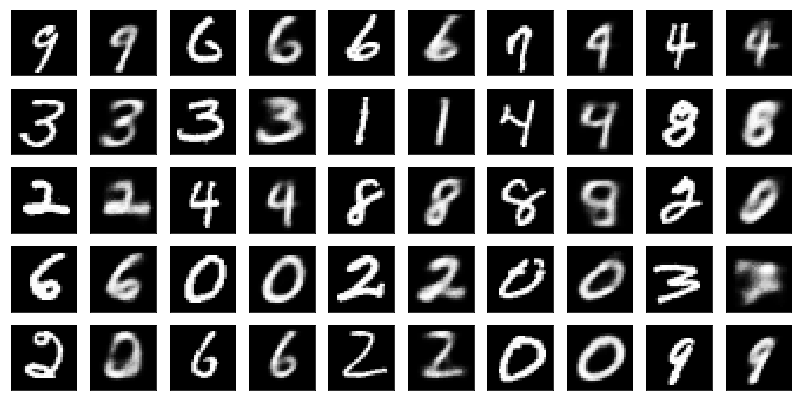

In [28]:
plot_reconstructions(enc, dec)

In [39]:
def plot_interpolations(encoder, decoder):
    batch = encoder(test_data[np.random.choice(10000, 10)][0])
    z_0 = batch[:5, :d].view(5, 1, d)
    z_1 = batch[5:, :d].view(5, 1, d)
    alpha = torch.tensor(np.linspace(0., 1., 10), dtype=torch.float32)
    alpha = alpha.view(1, 10, 1)
    interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
    interpolations_z = interpolations_z.view(50, d)
    interpolations_x = nn.functional.sigmoid(decoder(interpolations_z))
    interpolations_x = interpolations_x.view(5, 10, 28, 28).data.numpy()
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

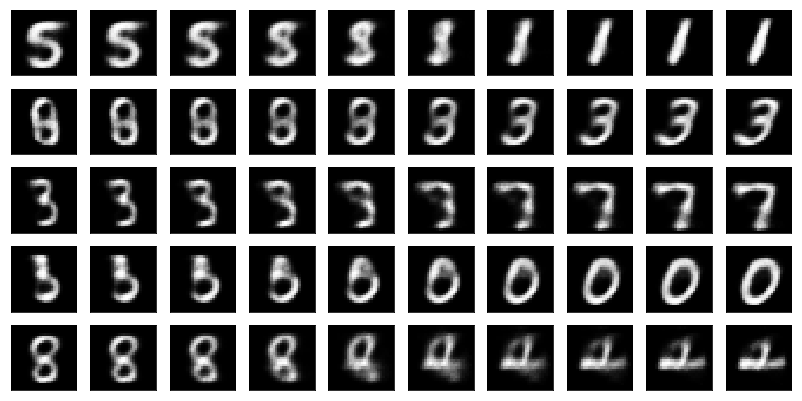

In [40]:
plot_interpolations(enc, dec)

In [41]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

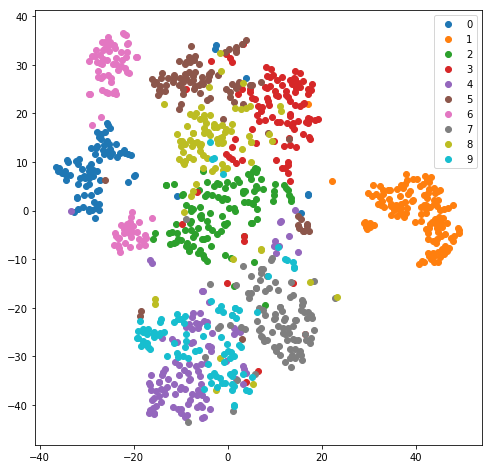

In [42]:
latent_variables = enc(test_data[:1000][0])[:, :d]
latent_variables = latent_variables.data.numpy()
labels = test_data[:1000][1].numpy()

plot_tsne(latent_variables, labels)

# Semi-supervised VAE model

This part of notebook is inspired by ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf). We will also use this model to illustrate the Gumbel-Softmax distribution.

In the semi-supervised setting, the generative model is a little more complicated. In particular, it incorporates a new variable $y$ that represents the digits class.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

Typically, whenever we train a model with partial observations, we interpret unobserved variables as latent variables and marginalize over them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

### ELBO for observed variables

Similiar to VAE:

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

### ELBO for unobserved variables

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

### The final objective

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

Again, we will use reparametrized Monte-Carlo estimates to approximate expectation over $z$. To approximate expectaion over discrete variables $y$ we will use Gumbel-Softmax trick.

# Important practical aspect

ELBO maximization does not lead to any semantics in latent variables $y$. 

We are going to restrict variational approximations $q(y \mid x)$ to the ones that correctly classify observation $x$ on fully-observed variables $(x_i, y_i)$. As in the original paper, we will add a cross-entropy regularizer to the objective with weight $\alpha$:

\begin{equation}
\frac{1}{|P|}\sum_{i \in P} y_i^T \log q(y \mid x).
\end{equation}

## RelaxedOneHotCategorical

In the probabilistic model defined above we are going to replace categorical prior $p(y)$ and categorical variational approximation $q(y | x)$ with Gumbel-Softmax distribution. The distribution class is implemented below:

For more details see [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144).

In [43]:
class RelaxedOneHotCategorical():
    def __init__(self, logits, temperature):
        self.k = torch.tensor([logits.shape[1]], dtype=torch.float32)
        self.logits = logits
        self.temperature = torch.tensor([temperature])

    def log_prob(self, x):
        log_Z = (torch.lgamma(self.k) + (self.k - 1) * self.temperature.log())
        log_prob_unnormalized = (nn.functional.log_softmax(
            self.logits - self.temperature * x.log(), dim=1) - x.log()).sum(1)
        return log_prob_unnormalized + log_Z
    
    def sample(self):
        gumbel = -(-torch.rand_like(self.logits).log()).log()
        sample = nn.functional.softmax((self.logits + gumbel) / self.temperature, dim=1)
        return sample

### An illustration for Gumbel-Softmax

- Temperature allows for smooth interpolation between one-hot categorical distribution with low temperature and a $(1/K, \dots, 1/K)$ vector with high temperatures
- The exact computation of $\mathbb E_{q(y|x)} f(y)$ requires computation of $f(y)$ for ten possible labels $y=0, \dots, 9$. On the other hand, with Gumbel-Softmax relaxation only one sample $y \sim q(y | x)$ is enough. Therefore, Gumbel-Softmax gives almost a ten-fold training speed increase.

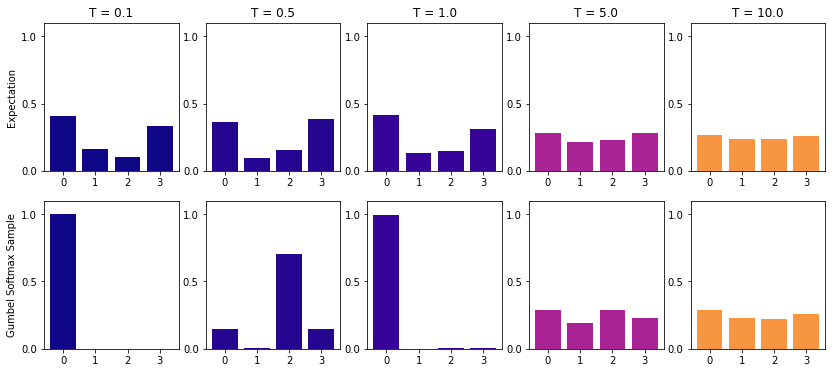

In [44]:
import matplotlib.cm as cm
n_classes = 4
logits = torch.randn(1, n_classes)
temperatures = [0.1, 0.5, 1., 5., 10.]
M = 128 # number of samples used to approximate distribution mean

fig, axes = plt.subplots(nrows=2, ncols=len(temperatures), figsize=(14, 6),
                         subplot_kw={'xticks': range(n_classes),
                                     'yticks': [0., 0.5, 1.]})
axes[0, 0].set_ylabel('Expectation')
axes[1, 0].set_ylabel('Gumbel Softmax Sample')

for n, t in enumerate(temperatures):
    dist = RelaxedOneHotCategorical(logits, t)
    mean = torch.zeros_like(logits)
    for _ in range(M):
        mean += dist.sample() / M
    sample = dist.sample()
    
    axes[0, n].set_title('T = {}'.format(t))
    axes[0, n].set_ylim((0, 1.1))
    axes[1, n].set_ylim((0, 1.1))
    axes[0, n].bar(np.arange(n_classes), mean.numpy().reshape(n_classes),
                   color=cm.plasma(0.75 * t / max(temperatures)))
    axes[1, n].bar(np.arange(n_classes), sample.numpy().reshape(n_classes),
                   color=cm.plasma(0.75 * t / max(temperatures)))

# SS-VAE implementation

The computational graph for observed labels has the following structure:

![computational graph ss vae xy](ss_vae_xy.png)

The computational graph for unobserved lables has the following structure:

![computational graph ss vae xy](ss_vae_x.png)

In [45]:
n_classes, d, nh, D = 10, 32, 500, 28 * 28

yz_dec = nn.Sequential(
    nn.Linear(n_classes + d, nh),
    nn.ReLU(),
    nn.Linear(nh, D))

y_enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, n_classes))

z_enc = nn.Sequential(
    nn.Linear(n_classes + D, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)
    )

In [46]:
def loss(x, y, y_encoder, z_encoder, decoder, T=0.6, alpha=32.):#, verbose=False):
    ################################################################################
    # NOTE:                                                                        #
    # hyperparameter alpha was tuned for the implementation that computed  mean of #
    # elbo terms and sum of cross-entropy terms over observed datapoints in batch  #
    ################################################################################
    y_is_observed = y.sum(1, keepdim=True)
    # sample y from q(y | x)
    qy_x = RelaxedOneHotCategorical(y_encoder(x), T)
    y_gumbel = qy_x.sample()
    y_to_decode = y_gumbel * (1 - y_is_observed) + y * y_is_observed
    # sample z from q(z | x, y)
    qz_xy_loc_scale = z_encoder(torch.cat((x, y_to_decode), 1))
    qz_xy = MultivariateNormalDiag(
        qz_xy_loc_scale[:, :d],
        nn.functional.softplus(qz_xy_loc_scale[:, d:]))
    z = qz_xy.sample()    
    # compute the evidence lower bound
    py = RelaxedOneHotCategorical(torch.zeros_like(y_gumbel), T)
    pz = MultivariateNormalDiag(torch.zeros_like(z), torch.ones_like(z))
    px_yz_logits = decoder(torch.cat((y_to_decode, z), 1))
    px_yz = BernoulliVector(px_yz_logits)
    
    loss = (px_yz.log_prob(x) + pz.log_prob(z) - qz_xy.log_prob(z)
            + (py.log_prob(y_gumbel) - qy_x.log_prob(y_gumbel)) * (1 - y_is_observed)).mean()
    # compute the cross_entropy regularizer with weight alpha
    loss_supervised = (
        y_is_observed
        * (y * nn.functional.log_softmax(y_encoder(x), dim=1))).sum()
    return loss + alpha * loss_supervised

In [49]:
from itertools import chain

def train_model(y_encoder, z_encoder, decoder, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = optim.Adam(chain(y_encoder.parameters(),
                          z_encoder.parameters(),
                          decoder.parameters()), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_losses = []
    for _ in range(num_epochs):
        for i, (x, y) in enumerate(dataloader):
            total = len(dataloader)
            loss_value = loss(x, y, y_encoder, z_encoder, decoder)
            (-loss_value).backward()
            train_losses.append(loss_value.cpu().item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
            gd.zero_grad()
        loss_value = 0.
        accuracy = 0.
        for i, (x, y) in enumerate(test_dataloader):
            total = len(test_dataloader)
            loss_value += loss(x, torch.zeros((y.shape[0], 10)), y_encoder, z_encoder, decoder).item()
            accuracy += (torch.argmax(y_encoder(x), 1) == y).double().mean().item()
        print('Test loss: {}\t Test accuracy: {}'.format(loss_value / total, accuracy / total))

Neural networks

In [50]:
# my implementation omitted log p(y) for observed variables. it has
# test loss -106.79
# test accuracy 0.95
train_model(y_enc, z_enc, yz_dec, num_epochs=16)

Train loss: -172.78021240234375 Batch 600 of 600           loss: -122.69620330810547
accuracy: 0.9350999999999999
Train loss: -152.24264526367188 Batch 600 of 600           loss: -119.3888247680664
accuracy: 0.9335999999999999
Train loss: -123.75426483154297 Batch 600 of 600           loss: -117.2235368347168
accuracy: 0.9357000000000003
Train loss: -115.43663024902344 Batch 600 of 600           loss: -115.44101669311523
accuracy: 0.9415999999999997
Train loss: -139.0586700439453 Batch 600 of 600            loss: -114.25745506286621
accuracy: 0.9462999999999999
Train loss: -111.40328979492188 Batch 600 of 600           loss: -111.90113494873047
accuracy: 0.9501000000000001
Train loss: -116.46405029296875 Batch 600 of 600           loss: -110.81942817687988
accuracy: 0.9493000000000003
Train loss: -106.52008819580078 Batch 600 of 600           loss: -110.01765899658203
accuracy: 0.9529999999999998
Train loss: -110.87140655517578 Batch 600 of 600           loss: -109.4703133392334
accura

## Visualizations

Generate 10 images for each label

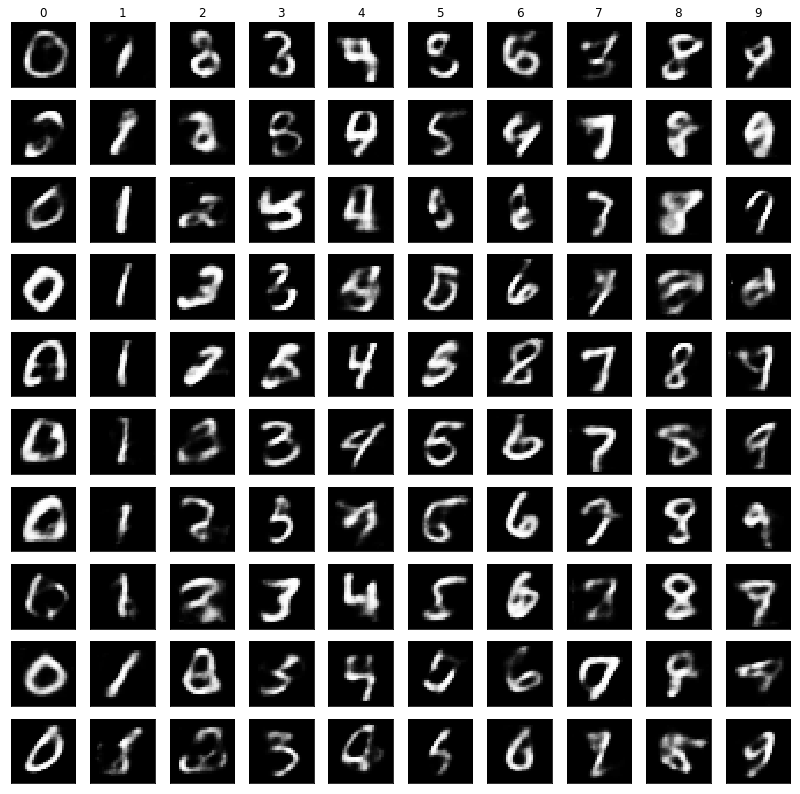

In [51]:
def plot_samples_with_fixed_classes(dec):
    decoder_input = torch.cat((torch.eye(10).repeat(10, 1), torch.randn(100, d)), 1)
    images = nn.functional.sigmoid(dec(decoder_input)).view(100, 28, 28).data.numpy()
    
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(14, 14),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(10):
        axes[0, i].set_title('{}'.format(i))
    
    for i in range(100):
        axes[int(i / 10), i % 10].imshow(images[i], cmap='gray')
        
plot_samples_with_fixed_classes(yz_dec)

### "Style-transfer"

Here we infer latent representation $z$ of a given digit $x$ and then generate from $p(x | z, y)$ for different $y$.

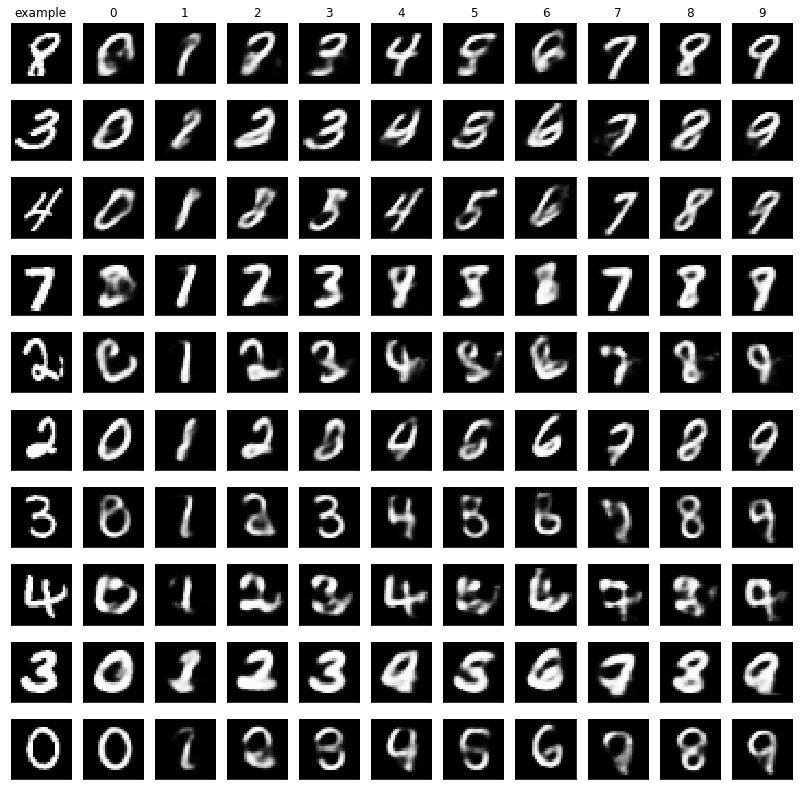

In [52]:
def plot_all_digits_with_fixed_style(z_enc, y_enc, dec):
    indices = np.random.choice(10000, 10)
    x, y = test_data[indices][0], torch.eye(10)[test_data[indices][1]]
    z = z_enc(torch.cat((x, y), 1))[:, :d]

    # generate digits
    images = []
    for i in range(10):
        digit_encodings = torch.eye(10)[i, :].expand(10, 10)
        images.append(nn.functional.sigmoid(dec(torch.cat((digit_encodings, z), 1)).view(10, 28, 28)).data.numpy())
        
    x = x.view(10, 28, 28).numpy()

    # plot
    fig, axes = plt.subplots(nrows=10, ncols=11, figsize=(14, 14),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    axes[0, 0].set_title('example')
    for i in range(10):
        axes[0, i + 1].set_title('{}'.format(i))
        axes[i, 0].imshow(x[i], cmap='gray')
        for j in range(10):
            axes[i, j + 1].imshow(images[j][i], cmap='gray')
            
plot_all_digits_with_fixed_style(z_enc, y_enc, yz_dec)

### T-SNE for SS-VAE

Do you notice any difference from T-SNE for vanilla VAE? How can you interpret the results?

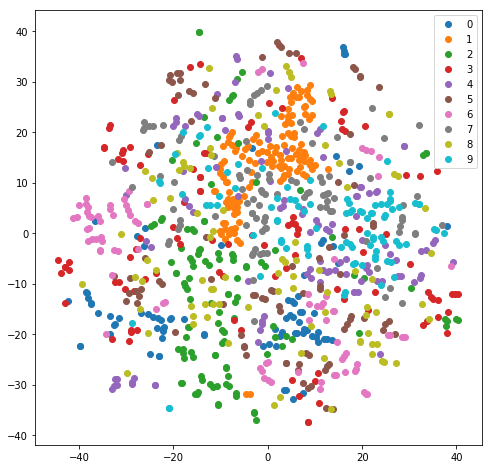

In [53]:
# T-SNE for q(z | x, y) mean
labels = test_data[:1000][1].numpy()
encoder_input = torch.cat((test_data[:1000][0], torch.eye(10)[labels]), 1)
latent_variables = z_enc(encoder_input)[:, :d]
latent_variables = latent_variables.data.numpy()

plot_tsne(latent_variables, labels)

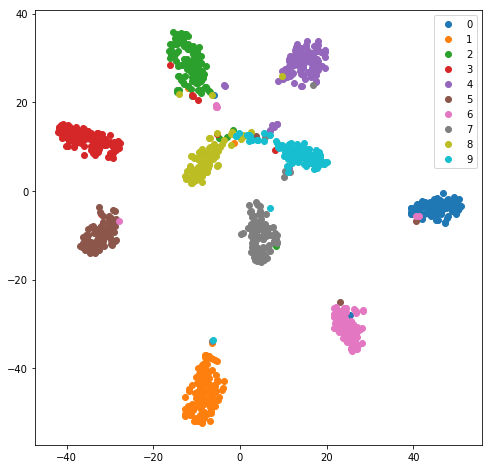

In [54]:
# T-SNE for q(y | x) logits
labels = test_data[:1000][1].numpy()
latent_variables = y_enc(test_data[:1000][0])
latent_variables = latent_variables.data.numpy()

plot_tsne(latent_variables, labels)